In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [38]:
VGG16 = [
    64,
    64,
    "M",
    128,
    128,
    "M",
    256,
    256,
    256,
    "M",
    512,
    512,
    512,
    "M",
    512,
    512,
    512,
    "M",
]

In [39]:
class VGG16NET(nn.Module):
    def __init__(self, in_channels=3, num_classes=100):
        super().__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_layers(VGG16)
        self.fcs = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.shape[0], -1)
        x = self.fcs(x)
        
        return x

    def create_layers(self, architecture):
        layers = []
        in_channels = self.in_channels
        for i in architecture:
            if type(i) == int:
                out_channels = i
                layers += [
                    nn.Conv2d(
                        in_channels,
                        out_channels,
                        kernel_size=(3, 3),
                        stride=(1, 1),
                        padding=(1, 1),
                    ),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(),
                ]
                in_channels = i
            else:
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]
        return nn.Sequential(*layers)

In [40]:
model = VGG16NET(3, 100)

In [41]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [
        transforms.Resize((244, 244)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_dataset = torchvision.datasets.CIFAR100(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.CIFAR100(
    root="./data", train=False, download=True, transform=transform
)

batch_size = 64
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

Files already downloaded and verified
Files already downloaded and verified


In [42]:
batch_size = 64
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size]
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=batch_size, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


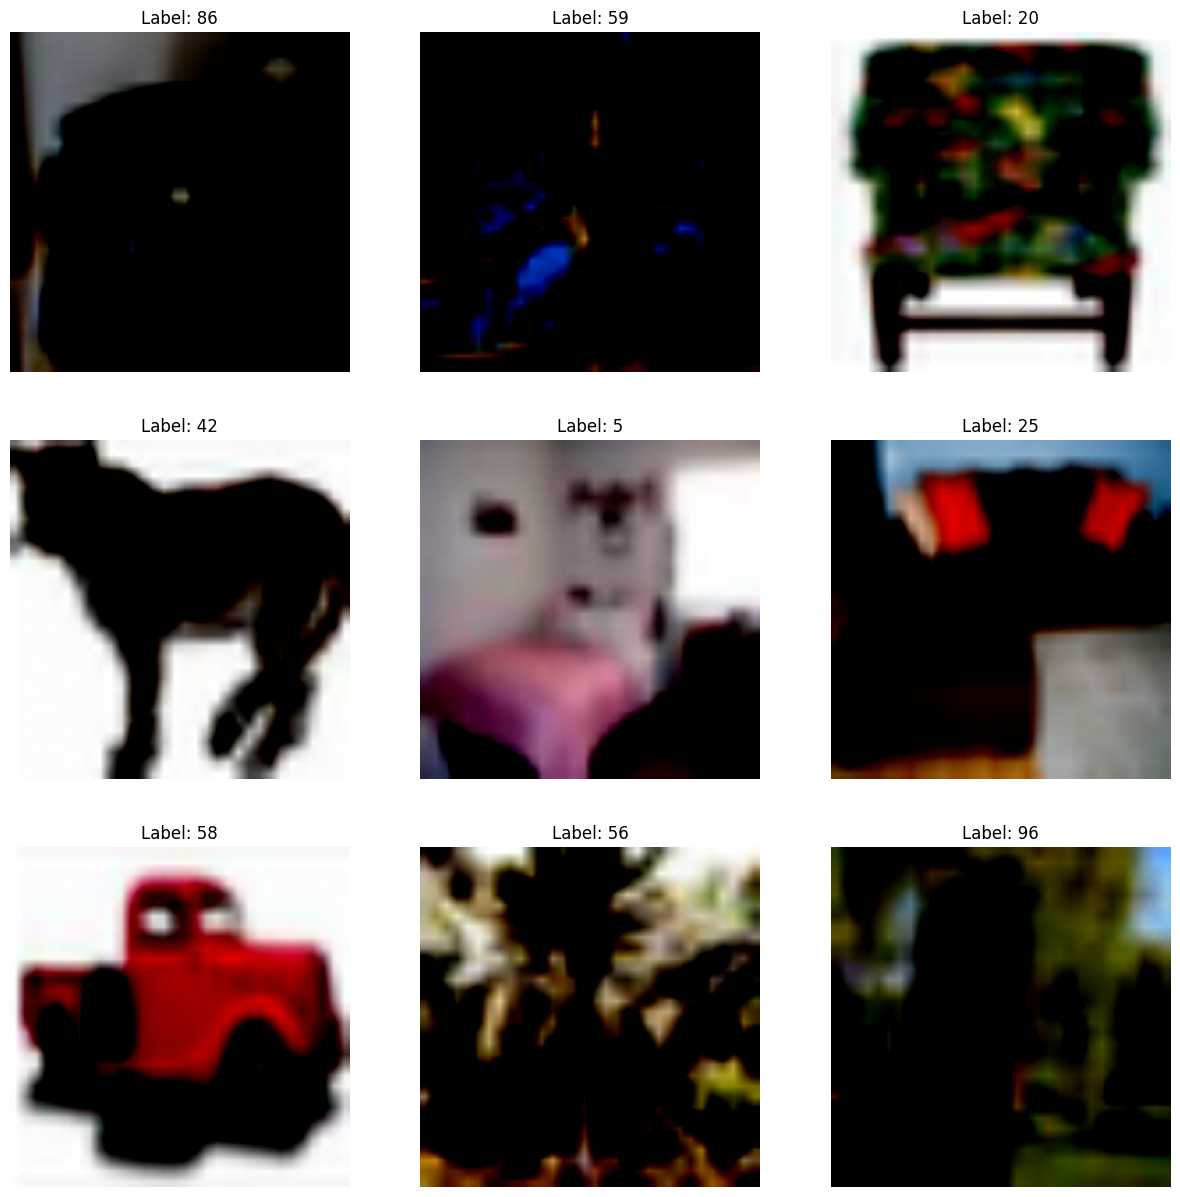

In [43]:
def plot_samples(loader):
    for images, labels in loader:
        fig, axs = plt.subplots(3, 3, figsize=(15, 15))

        axs = axs.flatten()

        for i in range(9):
            image = images[i].numpy().transpose((1, 2, 0))
            label = labels[i].item()

            axs[i].imshow(image)
            axs[i].set_title(f"Label: {label}")
            axs[i].axis("off")

        plt.show()
        break


plot_samples(train_loader)
plt.show()

In [44]:
model = VGG16NET().to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
NUM_EPOCHS = 32

train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    average_train_loss = total_train_loss / len(train_loader)
    train_losses.append(loss.item())
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to("cuda"), labels.to("cuda")
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    average_val_loss = total_val_loss / len(val_loader)
    val_losses.append(loss.item())
    print(
        f"Epoch [{epoch + 1}/{NUM_EPOCHS}], "
        f"Train Accuracy: {train_accuracy:.2f}%, Train Loss: {average_train_loss:.4f}, "
        f"Validation Accuracy: {val_accuracy:.2f}%, Validation Loss: {average_val_loss:.4f}"
    )

In [ ]:
plt.plot(range(NUM_EPOCHS), train_losses, label="Training Loss")
plt.plot(range(NUM_EPOCHS), val_losses, label="Validation Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
import torch
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
)

model.eval()

all_predictions = []
all_labels = []

with torch.inference_mode():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        outputs = model(inputs)

        _, predictions = torch.max(outputs, 1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average="weighted")
precision = precision_score(all_labels, all_predictions, average="weighted")
recall = recall_score(all_labels, all_predictions, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

print("Classification Report:")
print(classification_report(all_labels, all_predictions))

conf_matrix = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(conf_matrix)